In [27]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [28]:
a = mnist.train.num_examples
b = mnist.validation.num_examples
c = mnist.test.num_examples
print(a, b, c)
batch_size = 128

55000 5000 10000


In [29]:
num_step = int(a/batch_size)
e = 0
for i in range(num_step+1):
    d = mnist.train.next_batch(batch_size)
    e += d[0].shape[0]
print(d[0].shape)
print(e)

(128, 784)
55040


In [30]:
# Training Params
num_steps = 1000000
batch_size = 128
learning_rate = 0.0002

# Network Params
image_dim = 784 # 28*28 pixels
gen_hidden_dim = 256
disc_hidden_dim = 256
noise_dim = 100 # Noise data points

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

def sample_z(n_sample, n_dim):
    return np.random.uniform(-1., 1., size=[n_sample, n_dim])

In [31]:

# Store layers weight & bias
weights = {
    'gen_hidden1': tf.Variable(glorot_init([noise_dim, gen_hidden_dim])),
    'gen_out': tf.Variable(glorot_init([gen_hidden_dim, image_dim])),
    'disc_hidden1': tf.Variable(glorot_init([image_dim, disc_hidden_dim])),
    'disc_out': tf.Variable(glorot_init([disc_hidden_dim, 1])),
}
biases = {
    'gen_hidden1': tf.Variable(tf.zeros([gen_hidden_dim])),
    'gen_out': tf.Variable(tf.zeros([image_dim])),
    'disc_hidden1': tf.Variable(tf.zeros([disc_hidden_dim])),
    'disc_out': tf.Variable(tf.zeros([1])),
}

In [32]:
# Generator
def generator(x):
    hidden_layer = tf.matmul(x, weights['gen_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['gen_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['gen_out'])
    out_layer = tf.add(out_layer, biases['gen_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer


# Discriminator
def discriminator(x):
    hidden_layer = tf.matmul(x, weights['disc_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['disc_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['disc_out'])
    out_layer = tf.add(out_layer, biases['disc_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

# Build Networks
# Network Inputs
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
disc_input = tf.placeholder(tf.float32, shape=[None, image_dim], name='disc_input')

# Build Generator Network
gen_sample = generator(gen_input)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(disc_input)
disc_fake = discriminator(gen_sample)

# Build Loss
gen_loss = -tf.reduce_mean(disc_fake)
disc_loss = tf.reduce_mean(disc_real) - tf.reduce_mean(disc_fake)
# Build Optimizers
optimizer_gen = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.RMSPropOptimizer(learning_rate=learning_rate)

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Generator Network Variables
gen_vars = [weights['gen_hidden1'], weights['gen_out'],
            biases['gen_hidden1'], biases['gen_out']]
# Discriminator Network Variables
disc_vars = [weights['disc_hidden1'], weights['disc_out'],
            biases['disc_hidden1'], biases['disc_out']]
clip_D = [p.assign(tf.clip_by_value(p, -.05, .05)) for p in disc_vars]
# Create training operations
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(-disc_loss, var_list=disc_vars)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [33]:
# Start Training
# Start a new TF session
# writer = tf.summary.FileWriter('./graphs/GAN_TF_Tutorial', tf.get_default_graph())
loss_D = []
loss_G = []
sess = tf.Session()

# Run the initializer
sess.run(init)
writer = tf.summary.FileWriter('./graphs/GAN_TF_Tutorial', tf.get_default_graph())
# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])

    # Train
    feed_dict = {disc_input: batch_x, gen_input: z}
    _, _, gl, dl, _ = sess.run([train_gen, train_disc, gen_loss, disc_loss, clip_D],
                            feed_dict=feed_dict)
    if i % 20000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
    if i%10==0:
        loss_D.append(dl)
        loss_G.append(gl)

Step 1: Generator Loss: -0.636009, Discriminator Loss: -0.092920
Step 20000: Generator Loss: -0.489283, Discriminator Loss: 0.066330
Step 40000: Generator Loss: -0.477642, Discriminator Loss: 0.055867
Step 60000: Generator Loss: -0.468909, Discriminator Loss: 0.065211
Step 80000: Generator Loss: -0.473995, Discriminator Loss: 0.037231
Step 100000: Generator Loss: -0.370943, Discriminator Loss: 0.044899
Step 120000: Generator Loss: -0.511830, Discriminator Loss: 0.026890
Step 140000: Generator Loss: -0.483991, Discriminator Loss: 0.034015
Step 160000: Generator Loss: -0.470977, Discriminator Loss: 0.031982
Step 180000: Generator Loss: -0.461416, Discriminator Loss: 0.023584
Step 200000: Generator Loss: -0.487980, Discriminator Loss: 0.028253
Step 220000: Generator Loss: -0.469242, Discriminator Loss: 0.028774
Step 240000: Generator Loss: -0.474113, Discriminator Loss: 0.036211
Step 260000: Generator Loss: -0.466549, Discriminator Loss: 0.020936
Step 280000: Generator Loss: -0.469792, Di

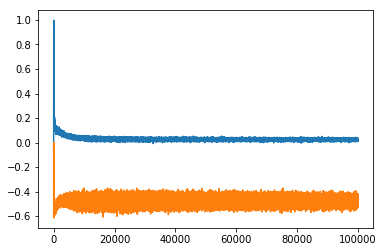

In [44]:
xplot = np.arange(num_steps/10)
plt.plot(xplot, loss_D)
plt.plot(xplot, loss_G)
# plt.ylim([-0.5, -0.4])
# plt.xlim([20000, 20100])
plt.show()

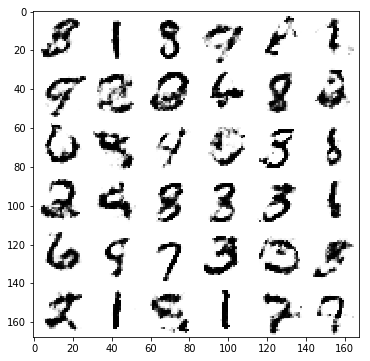

In [35]:

# Testing
# Generate images from noise, using the generator network.
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[n, noise_dim])
    # Generate image from noise.
    g = sess.run(gen_sample, feed_dict={gen_input: z})
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()